#Plasmid stability 
## Different fractions of plasmid bearing strain were mixed with WT strain.
## Each fraction were submitted to different antibiotic concentration and the resulting fraction was stimated.

## Prepare file system

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os
from scipy.optimize import curve_fit

### Load auxiliary functions


In [2]:
def make_cobweb(poly,seed):
    seed_t=-10 
    xc=[]
    yc=[]
    flag=-1
    thr=20
    c=0
    while(thr>1e-3 and c<100):
        thr=abs(seed-seed_t)
        c=c+1
        if(flag==-1):
            seed_t=seed
            val=poly(seed)
            xc.append(seed)
            yc.append(val)
            seed=val
        else:
            xc.append(seed)
            yc.append(seed)
            #seed=
            
        flag=flag*-1
        
        #print(seed,seed_t,thr)
    return xc,yc

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def f0(x,g,mu):
    y=x*(1-g)/(x*(1-g)+(1-x))*(1-mu)
    return y

def f1(x,gamma,alpha,mu):
    y=x*((1-gamma)/((1-alpha)+x*(alpha-gamma)))*(1-mu)
    return y
epsg=1e-4


### Mount Gdrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set paths

In [5]:
project_path="/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/"   ####  <-------------------- check

data_path=project_path+"data/Synergy_191109/"

figures_path=project_path+"figures/"
table_path=project_path+"data/parameters/"
dfs_path=project_path+"data/experimental_dataframes/"


reps=["rep-1","rep-2","rep-3","rep-4"]
hours=["16h","24h"]      

freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 'x']
cols=[x for x in np.arange(1,13)]

freqs_dict=dict(zip(cols,freqs))

print(freqs_dict)
rows="A B C D E F G H"
rows=rows.split()
amps=[0,1,2,2.5,3,3.5,4,6]
amp_dict=dict(zip(rows,amps))

print(amp_dict)


{1: 0, 2: 0.1, 3: 0.2, 4: 0.3, 5: 0.4, 6: 0.5, 7: 0.6, 8: 0.7, 9: 0.8, 10: 0.9, 11: 1, 12: 'x'}
{'A': 0, 'B': 1, 'C': 2, 'D': 2.5, 'E': 3, 'F': 3.5, 'G': 4, 'H': 6}


### Load growth rate parameters


In [6]:
params_path=project_path+"data/parameters/"
params_file=params_path+"parameters_table.csv"
#params_file=params_path+"params_table_short.csv"
growth_params=pd.read_csv(params_file) 

mu_n=float(growth_params[growth_params["Parameter"]=="μ_n"]["Estimated value"])

print(mu_n)
growth_params

5.93866169917856e-06


,Parameter,Measured value,Formula,Estimated value,Description
0,r,0.435435,NaN,NaN,plasmid strain growth rate
1,ρ,0.052335,NaN,NaN,WT growth rate advantage
2,σ,6.074090,NaN,NaN,exponential phase duration
3,μ_n,NaN,μ_n1-( ((r*2^-n)+ρ)/( (r*2^-n)*exp((r*2^-n+ρ)*...,0.000006,1-day fraction of segregants
4,κ_n,NaN,κ_n=(ρ*(1-exp(-(r*2^-n+ρ)*σ)) )/(ρ+r*2^-n),0.272314,fitness cost
5,n,19.000000,NaN,NaN,plasmid copy number


### Load innoculation plate culture (starting fractions)

In [13]:
file=data_path+"ON.txt"
df_ON=pd.read_csv(file,skiprows=51,sep="\t",index_col=0)
df_ON=df_ON.drop("Unnamed: 97",axis=1)
df_ON


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
Well,,,,,,,,,,,,,,,,,,,,,
OD:630,0.761,0.74,0.741,0.754,0.735,0.726,0.753,0.716,0.773,0.742,...,0.736,0.733,0.744,0.715,0.716,0.716,0.718,0.718,0.692,0.088
"GFP:479,520",29884.000,72995.00,113699.000,149634.000,195849.000,229290.000,281736.000,326306.000,345019.000,412406.000,...,112566.000,155659.000,200653.000,230011.000,285131.000,326623.000,370410.000,413130.000,433634.000,1978.000
GFP/OD,39285.000,98602.00,153399.000,198506.000,266534.000,315696.000,374102.000,455480.000,446453.000,555728.000,...,152985.000,212417.000,269550.000,321514.000,398283.000,456050.000,516179.000,575550.000,626911.000,22350.000


In [14]:
df_ONod=df_ON[df_ON.index=='OD:630']
df_ONgfp=df_ON[df_ON.index=='GFP:479,520']
df_ONratio=df_ON[df_ON.index=='GFP/OD']
df_ONratio

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
Well,,,,,,,,,,,,,,,,,,,,,
GFP/OD,39285.0,98602.0,153399.0,198506.0,266534.0,315696.0,374102.0,455480.0,446453.0,555728.0,...,152985.0,212417.0,269550.0,321514.0,398283.0,456050.0,516179.0,575550.0,626911.0,22350.0


### Load experments results (Final fractions)

In [17]:
df_list=[]
for rep in reps:
    for hr in hours:
        file=data_path+rep+"_"+hr+".txt"
        print(file)
        rpl=[rep]*3
        hr=int(hr.split("h")[0])
        hrl=[hr]*3
        this_df=pd.read_csv(file,skiprows=51,sep="\t",index_col=0,encoding='iso-8859-1')
        #keys=this_df
        tmp=pd.DataFrame({"Rep":rpl,"Time":hrl}, index=this_df.index)
        #this_df.join(tmp)
        this_df=pd.merge(this_df,tmp,left_index=True,right_index=True)
        this_df=this_df.drop("Unnamed: 97",axis=1)
        df_list.append(this_df)
all_df=pd.concat(df_list)
all_df.head()

/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-1_16h.txt
/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-1_24h.txt
/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-2_16h.txt
/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-2_24h.txt
/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-3_16h.txt
/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-3_24h.txt
/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-4_16h.txt
/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/data/Synergy_191109/rep-4_24h.txt


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H5,H6,H7,H8,H9,H10,H11,H12,Rep,Time
Well,,,,,,,,,,,,,,,,,,,,,
OD:630,0.657,0.666,0.647,0.792,0.694,0.849,0.595,0.808,0.607,0.586,...,0.662,0.731,0.649,0.608,0.586,0.562,0.585,0.088,rep-1,16
"GFP:479,520",31116.000,47671.000,61381.000,82434.000,96187.000,133985.000,117369.000,189509.000,157888.000,172327.000,...,105562.000,135679.000,144725.000,155330.000,165461.000,182778.000,207383.000,28028.000,rep-1,16
GFP/OD,47382.000,71524.000,94914.000,104110.000,138678.000,157908.000,197292.000,234599.000,260198.000,293973.000,...,159339.000,185531.000,222860.000,255519.000,282453.000,325459.000,354743.000,318500.000,rep-1,16
OD:630,1.014,1.095,0.385,0.984,0.520,0.636,0.532,0.619,0.599,0.426,...,0.425,0.539,0.547,0.552,0.549,0.593,0.512,0.087,rep-1,24
"GFP:479,520",23464.000,47679.000,46733.000,78754.000,73575.000,88558.000,91663.000,114338.000,127069.000,105931.000,...,138408.000,171976.000,185585.000,180584.000,173043.000,186139.000,166445.000,23371.000,rep-1,24


In [18]:
df_od=all_df[all_df.index=='OD:630']
df_gfp=all_df[all_df.index=='GFP:479,520']
df_ratio=all_df[all_df.index=='GFP/OD']

df_od.reset_index(inplace=True,drop=True)
df_gfp.reset_index(inplace=True,drop=True)
df_ratio.reset_index(inplace=True,drop=True)

df_ratio

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H5,H6,H7,H8,H9,H10,H11,H12,Rep,Time
0,47382.0,71524.0,94914.0,104110.0,138678.0,157908.0,197292.0,234599.0,260198.0,293973.0,...,159339.0,185531.0,222860.0,255519.0,282453.0,325459.0,354743.0,318500.0,rep-1,16
1,23149.0,43527.0,121258.0,80026.0,141436.0,139330.0,172234.0,184625.0,212171.0,248373.0,...,325819.0,318828.0,339092.0,327026.0,314910.0,314000.0,324898.0,268632.0,rep-1,24
2,34947.0,88810.0,79507.0,96228.0,124651.0,149942.0,165808.0,197718.0,219708.0,252272.0,...,163523.0,196503.0,217466.0,244473.0,265532.0,282838.0,323204.0,312163.0,rep-2,16
3,72159.0,82863.0,118065.0,91707.0,121950.0,128808.0,153419.0,185059.0,185606.0,210489.0,...,324440.0,309530.0,317342.0,305010.0,304100.0,307238.0,323586.0,272154.0,rep-2,24
4,35856.0,62502.0,88200.0,110568.0,138268.0,178047.0,201723.0,260279.0,274361.0,336456.0,...,174815.0,208468.0,242236.0,275548.0,317003.0,330622.0,426200.0,312164.0,rep-3,16
5,66710.0,104703.0,111805.0,159153.0,161788.0,148121.0,175181.0,214157.0,246413.0,272952.0,...,378048.0,382442.0,373269.0,370853.0,389888.0,384937.0,446908.0,275000.0,rep-3,24
6,50049.0,60051.0,80663.0,108721.0,141943.0,169780.0,211018.0,240198.0,273998.0,318416.0,...,196109.0,214677.0,237303.0,267845.0,318130.0,372638.0,415102.0,298219.0,rep-4,16
7,45701.0,72821.0,100265.0,100027.0,141680.0,142336.0,184688.0,215642.0,259116.0,313894.0,...,367505.0,385460.0,394992.0,388767.0,390656.0,391345.0,422768.0,266192.0,rep-4,24


## Overnight overview

In [19]:
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        print(this_key,end='\t')
    print()


print("Overnight OD")
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        val=df_ONod[this_key][0]
        val=round(val,3)
        #val=int(val)
        print(val,end='\t')
    print()
c1s=["A12","B12","C12","D12","E12","F12","G12","H12"]
#c1s=["A1","B1","C1","D1","E1","F1","G1","H1"]


xx=[df_ONod[df_ONod.columns & c1s ][c][ri] for c in c1s for ri in range(0,1) ]
bg_od=np.mean(xx)


print("Overnight OD dbg: ",bg_od)
df_ONodDbg=df_ONod.copy()
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        val=df_ONod[this_key][0]-.09
        val=round(val,3)
        if(val<.01):
            val=0
        df_ONodDbg[this_key]=val
        print(val,end='\t')
    print()


print("\n\nOvernight GFP")
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        val=df_ONgfp[this_key][0]
        val=int(val)
        #val=int(val)
        print(val,end='\t')
    print()

c1s=["A1","B1","C1","D1","E1","F1","G1","H1"]    
xx=[df_ONgfp[df_ONgfp.columns & c1s ][c][ri] for c in c1s for ri in range(0,1) ]
bg_GFP=np.mean(xx)
#bg_GFP=30000

print("Overnight GFP dbg:",bg_GFP)
df_ONgfpDbg=df_ONgfp.copy()
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        val=df_ONgfp[this_key][0]-bg_GFP
        if(val<2000):
            val=0
        #val=round(val,3)
        val=int(val)
        print(val,end='\t')
        df_ONgfpDbg[this_key]=val
    print()






print("\n\nOvernight GFP/OD")
df_ONratioLocal=df_ONratio.copy()

for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        valO=df_ONod[this_key][0]
        valG=df_ONgfp[this_key][0]
        val=round(valG/valO,0)
        val=int(val)
        df_ONratioLocal[this_key]=val
        print(val,end='\t')
    print()


df_ONratioLocalDbg=df_ONratioLocal.copy()
print("Overnight GFP/OD dbg")
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        valO=df_ONodDbg[this_key][0]
        valG=df_ONgfpDbg[this_key][0]
        val=round(valG/valO,0)
        if(valO==0):
            val=0
        else:            
            val=int(val)
        
        df_ONratioLocalDbg[this_key]=val
        print(val,end='\t')
    print()

A1	A2	A3	A4	A5	A6	A7	A8	A9	A10	A11	A12	
B1	B2	B3	B4	B5	B6	B7	B8	B9	B10	B11	B12	
C1	C2	C3	C4	C5	C6	C7	C8	C9	C10	C11	C12	
D1	D2	D3	D4	D5	D6	D7	D8	D9	D10	D11	D12	
E1	E2	E3	E4	E5	E6	E7	E8	E9	E10	E11	E12	
F1	F2	F3	F4	F5	F6	F7	F8	F9	F10	F11	F12	
G1	G2	G3	G4	G5	G6	G7	G8	G9	G10	G11	G12	
H1	H2	H3	H4	H5	H6	H7	H8	H9	H10	H11	H12	
Overnight OD
0.761	0.74	0.741	0.754	0.735	0.726	0.753	0.716	0.773	0.742	0.754	0.091	
0.698	0.724	0.728	0.738	0.742	0.73	0.754	0.713	0.738	0.762	0.75	0.091	
0.75	0.753	0.763	0.721	0.751	0.736	0.743	0.711	0.722	0.717	0.717	0.09	
0.709	0.718	0.715	0.713	0.715	0.709	0.724	0.711	0.719	0.738	0.715	0.091	
0.696	0.73	0.721	0.715	0.71	0.72	0.713	0.709	0.715	0.746	0.74	0.089	
0.706	0.721	0.766	0.733	0.722	0.712	0.712	0.723	0.713	0.715	0.715	0.089	
0.764	0.771	0.753	0.773	0.712	0.755	0.734	0.715	0.734	0.734	0.748	0.089	
0.713	0.728	0.736	0.733	0.744	0.715	0.716	0.716	0.718	0.718	0.692	0.088	
Overnight OD dbg:  0.08975
0.671	0.65	0.651	0.664	0.645	0.636	0.663	0.626	0.683	0.652	0.664	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


337602	376816	421325	0	
0	42160	81885	121007	161528	197022	253874	290918	334165	379330	425676	0	
0	43036	82285	120953	158064	199778	245508	292381	334729	388199	430949	0	
0	41904	86454	123830	166303	196800	249324	296677	334691	376960	421781	0	
0	44932	85195	128731	161305	208533	255498	288744	342913	388355	440574	0	
0	42746	82618	125711	170705	200063	255183	296675	340462	383182	403686	0	


Overnight GFP/OD
39269	98642	153440	198454	266461	315826	374151	455735	446338	555803	614546	23890	
43731	100021	154714	208127	263342	319766	370760	453491	503022	482089	603804	22879	
39324	97412	151881	210886	263792	315997	387970	455075	509072	567314	629391	23333	
42213	100429	156410	211718	267799	320127	392019	451288	506416	554577	637236	22769	
43901	99978	155663	211050	264806	319064	386334	454625	510038	560519	622834	22876	
43238	99656	151961	209793	271816	318466	392236	451763	511415	569102	631789	22539	
37508	97121	152912	205277	268614	315869	388891	445723	507985	569895	629040	23258	
42094	99854	1529

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in long_scalars


## Raw data overview

In [20]:
print("wells")
time=[16,24]
#time=[24]


df_ratioLocal=df_ratio.copy()
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        this_key=r+str(c)
        print(this_key,end='\t')

    print()

print("\nOD")
this_df=df_od.copy()
for hr in time:
    for rep in reps:
        print(rep," - ",hr)
        for ri,r in enumerate(amp_dict.keys()):
            amp=amp_dict[r]
            for ci,c in enumerate(freqs_dict.keys()):
                freq=freqs_dict[c]
                #print(amp,freq,end="\t")
                this_key=r+str(c)
                val=float(this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key])
                val=round(val,3)
                print(val,end='\t')
            print() 

print("\nGFP")
this_df=df_gfp.copy()
for hr in time:
    for rep in reps:
        print(rep," - ",hr)
        for ri,r in enumerate(amp_dict.keys()):
            amp=amp_dict[r]
            for ci,c in enumerate(freqs_dict.keys()):
                freq=freqs_dict[c]
                #print(amp,freq,end="\t")
                this_key=r+str(c)
                val=float(this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key])
                val=int(val)
                print(val,end='\t')
            print() 

print("\nGFP/OD read")
this_df=df_ratio.copy()
for hr in time:
    for rep in reps:
        print(rep," - ",hr)
        for ri,r in enumerate(amp_dict.keys()):
            amp=amp_dict[r]
            for ci,c in enumerate(freqs_dict.keys()):
                freq=freqs_dict[c]
                #print(amp,freq,end="\t")
                this_key=r+str(c)
                val=float(this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key])
                val=int(val)
                print(val,end='\t')
            print() 


print("\nGFP/OD local")
for hr in time:
    for rep in reps:
        print(rep," - ",hr)
        for ri,r in enumerate(amp_dict.keys()):
            amp=amp_dict[r]
            for ci,c in enumerate(freqs_dict.keys()):
                freq=freqs_dict[c]
                this_key=r+str(c)
                valO=float(df_od[(df_od["Rep"]==rep)&(df_od["Time"]==hr)][this_key])
                valG=float(df_gfp[(df_gfp["Rep"]==rep)&(df_gfp["Time"]==hr)][this_key])
                val=round(valG/valO,0)
                val=int(val)
                i=df_ratioLocal.index[(df_ratioLocal["Time"]==hr)&(df_ratioLocal["Rep"]==rep)][0]
                df_ratioLocal.at[i,this_key]=val
                #df_ratioLocal.at[(df_ratioLocal["Time"]==hr)&(df_ratioLocal["Rep"]==rep),this_key]=val
                print(val,end='\t')
            print()
#df_ratioLocal

wells
A1	A2	A3	A4	A5	A6	A7	A8	A9	A10	A11	A12	
B1	B2	B3	B4	B5	B6	B7	B8	B9	B10	B11	B12	
C1	C2	C3	C4	C5	C6	C7	C8	C9	C10	C11	C12	
D1	D2	D3	D4	D5	D6	D7	D8	D9	D10	D11	D12	
E1	E2	E3	E4	E5	E6	E7	E8	E9	E10	E11	E12	
F1	F2	F3	F4	F5	F6	F7	F8	F9	F10	F11	F12	
G1	G2	G3	G4	G5	G6	G7	G8	G9	G10	G11	G12	
H1	H2	H3	H4	H5	H6	H7	H8	H9	H10	H11	H12	

OD
rep-1  -  16
0.657	0.666	0.647	0.792	0.694	0.849	0.595	0.808	0.607	0.586	0.943	0.136	
0.615	0.781	0.797	0.745	0.612	0.662	0.911	0.749	0.888	0.963	0.873	0.09	
0.586	0.876	0.926	0.784	0.888	0.771	0.711	0.583	0.573	0.583	0.569	0.088	
0.539	0.673	0.658	0.652	0.619	0.614	0.623	0.63	0.613	0.625	0.661	0.09	
0.491	0.65	0.666	0.797	0.866	0.677	0.583	0.62	0.568	0.545	0.545	0.089	
0.381	0.793	0.878	0.706	0.833	0.711	0.681	0.606	0.599	0.574	0.573	0.089	
0.37	0.807	0.609	0.638	0.627	0.604	0.583	0.712	0.549	0.744	0.636	0.089	
0.383	0.688	0.659	0.655	0.662	0.731	0.649	0.608	0.586	0.562	0.585	0.088	
rep-2  -  16
0.818	0.508	0.873	0.869	0.806	0.788	0.75	0.758	0.749	0.844	0.525	0

In [21]:
df_ratioLocal

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H5,H6,H7,H8,H9,H10,H11,H12,Rep,Time
0,47361.0,71578.0,94870.0,104083.0,138598.0,157815.0,197259.0,234541.0,260112.0,294073.0,...,159459.0,185607.0,222997.0,255477.0,282357.0,325228.0,354501.0,318500.0,rep-1,16
1,23140.0,43542.0,121384.0,80035.0,141490.0,139242.0,172299.0,184714.0,212135.0,248664.0,...,325666.0,319065.0,339278.0,327145.0,315197.0,313894.0,325088.0,268632.0,rep-1,24
2,34951.0,88880.0,79462.0,96228.0,124635.0,149904.0,165720.0,197640.0,219649.0,252332.0,...,163546.0,196450.0,217375.0,244332.0,265689.0,282924.0,323056.0,310791.0,rep-2,16
3,72209.0,82915.0,118180.0,91751.0,122025.0,128780.0,153487.0,184997.0,185606.0,210461.0,...,324213.0,309481.0,317592.0,304840.0,304049.0,307078.0,323646.0,272773.0,rep-2,24
4,35861.0,62470.0,88222.0,110500.0,138336.0,178102.0,201595.0,260451.0,274321.0,336514.0,...,174667.0,208505.0,242144.0,275656.0,316944.0,330622.0,426285.0,311455.0,rep-3,16
5,66725.0,104592.0,111877.0,158975.0,161979.0,148058.0,175137.0,214096.0,246253.0,272747.0,...,377830.0,382633.0,373032.0,370540.0,389888.0,384841.0,446689.0,274368.0,rep-3,24
6,50033.0,60080.0,80653.0,108693.0,141886.0,169801.0,210882.0,240284.0,274130.0,318156.0,...,196073.0,214834.0,237260.0,267845.0,318130.0,372482.0,415018.0,298860.0,rep-4,16
7,45708.0,72796.0,100189.0,99964.0,141573.0,142393.0,184656.0,215676.0,259216.0,313780.0,...,367505.0,385775.0,394926.0,388767.0,390445.0,390998.0,423063.0,267430.0,rep-4,24


### Debackgrounded data OD 

In [22]:
this_df=df_od.copy()
c1s=["A12","B12","C12","D12","E12","F12","G12","H12"]
#c1s=["A1","B1","C1","D1","E1","F1","G1","H1"]

xx=[this_df[this_df.columns & c1s ][c][ri] for c in c1s for ri in range(0,len(reps)) ]
bg_od=np.mean(xx)


#bg_od=.089
df_odDbg=df_od.copy()
for hr in time:
    for rep in reps:
        print(rep," - ",hr)
        for ri,r in enumerate(amp_dict.keys()):
            amp=amp_dict[r]
            for ci,c in enumerate(freqs_dict.keys()):
                freq=freqs_dict[c]
                this_key=r+str(c)
                val=float(this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key])-bg_od
                val=round(val,3)
                #print(val)
#                 if(abs(round(val,3))<.015):
#                     val=0
                if(val<.05):
                    print("*",end="")
                    val=0
                ti=df_odDbg.index[(df_odDbg["Time"]==hr)&(df_odDbg["Rep"]==rep)][0]
                df_odDbg.at[ti,this_key]=val
                #df_odDbg.at[(df_odDbg["Time"]==hr)&(df_odDbg["Rep"]==rep),this_key]=val
                print(val,end='\t')
            print()
#df_odDbg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """


rep-1  -  16
0.566	0.575	0.556	0.701	0.603	0.758	0.504	0.717	0.516	0.495	0.852	*0	
0.524	0.69	0.706	0.654	0.521	0.571	0.82	0.658	0.797	0.872	0.782	*0	
0.495	0.785	0.835	0.693	0.797	0.68	0.62	0.492	0.482	0.492	0.478	*0	
0.448	0.582	0.567	0.561	0.528	0.523	0.532	0.539	0.522	0.534	0.57	*0	
0.4	0.559	0.575	0.706	0.775	0.586	0.492	0.529	0.477	0.454	0.454	*0	
0.29	0.702	0.787	0.615	0.742	0.62	0.59	0.515	0.508	0.483	0.482	*0	
0.279	0.716	0.518	0.547	0.536	0.513	0.492	0.621	0.458	0.653	0.545	*0	
0.292	0.597	0.568	0.564	0.571	0.64	0.558	0.517	0.495	0.471	0.494	*0	
rep-2  -  16
0.727	0.417	0.782	0.778	0.715	0.697	0.659	0.667	0.658	0.753	0.434	*0	
0.567	0.699	0.683	0.668	0.675	0.636	0.626	0.624	0.669	0.538	0.494	*0	
0.363	0.815	0.697	0.685	0.673	0.677	0.656	0.652	0.665	0.687	0.67	*0	
0.42	0.688	0.652	0.633	0.628	0.605	0.621	0.582	0.609	0.607	0.674	*0	
0.336	0.675	0.66	0.656	0.697	0.625	0.638	0.589	0.631	0.655	0.667	*0	
0.24	0.684	0.636	0.647	0.626	0.603	0.618	0.634	0.756	0.642	0.623	*0	
0.254	0.6

### Debackgrounded data GFP

In [23]:
freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 'x']
cols=[x for x in np.arange(1,13)]

freqs_dict=dict(zip(cols,freqs))

c1s=["A12","B12","C12","D12","E12","F12","G12","H12"]
#c1s=["A1","B1","C1","D1","E1","F1","G1","H1"]

#bg_gfp=30000

df_gfpDbg=df_gfp.copy()
for hr in time:
    this_df=df_gfp.copy()
    this_df=this_df[this_df["Time"]==hr]
    #xx=[this_df[this_df.columns & c1s ][c][ri] for c in c1s for ri in range(0,len(reps)) ]
    xx=[this_df[(this_df["Rep"]==rep)][c].to_numpy()[0] for c in c1s for rep in reps ]
    print(xx)
    bg_gfp=np.mean(xx)
    #bg_gfp=27000
    print("Background GFP: ",bg_gfp)

    for rep in reps:
        print(rep," - ",hr)
        for ri,r in enumerate(amp_dict.keys()):
            amp=amp_dict[r]
            for ci,c in enumerate(freqs_dict.keys()):
                freq=freqs_dict[c]
                this_key=r+str(c)
                if(this_key=="A1"):
                    bg_gfp=this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key].to_numpy()[0]
                val=this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key].to_numpy()[0]-bg_gfp
                val=int(val)
                #if(abs(round(val,1))<1000):
                if(val<0):
              #  if(val<6500):
                    val=0
                ti=df_gfpDbg.index[(df_gfpDbg["Time"]==hr)&(df_gfpDbg["Rep"]==rep)][0]
                df_gfpDbg.at[ti,this_key]=val
                #df_gfpDbg.at[(df_gfpDbg["Time"]==hr)&(df_gfpDbg["Rep"]==rep),this_key]=val
                print(val,end='\t')
            print()
df_gfpDbg

[26296.0, 27775.0, 27395.0, 27172.0, 27482.0, 27351.0, 27282.0, 26578.0, 27745.0, 26569.0, 26881.0, 26709.0, 27206.0, 26534.0, 26400.0, 26552.0, 27517.0, 27530.0, 27069.0, 26188.0, 27619.0, 27501.0, 26810.0, 26710.0, 27780.0, 27191.0, 26753.0, 26752.0, 28028.0, 28282.0, 27408.0, 27794.0]
Background GFP:  27151.84375
rep-1  -  16
0	16555	30265	51318	65071	102869	86253	158393	126772	141211	278196	0	
476	17085	35684	49356	57197	80581	126112	123047	177135	244058	240927	0	
0	16732	35431	51324	73962	81868	93848	100463	110189	144506	167656	0	
0	16694	31811	47097	58398	70598	86761	111420	122171	149311	181725	0	
57	16384	29690	50715	73496	76241	85937	102243	112009	132096	160088	0	
1401	19586	39312	46787	78484	83625	97985	107154	123441	139905	167081	0	
0	22257	32908	47165	65661	79710	94552	135403	118583	194104	200825	0	
0	49310	53150	62131	74446	104563	113609	124214	134345	151662	176267	0	
rep-2  -  16
0	16561	40780	55032	71866	89534	95700	121221	135927	184378	145370	0	
0	17346	36126	50170	71038

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H5,H6,H7,H8,H9,H10,H11,H12,Rep,Time
0,0.0,16555.0,30265.0,51318.0,65071.0,102869.0,86253.0,158393.0,126772.0,141211.0,...,74446.0,104563.0,113609.0,124214.0,134345.0,151662.0,176267.0,0.0,rep-1,16
1,0.0,24215.0,23269.0,55290.0,50111.0,65094.0,68199.0,90874.0,103605.0,82467.0,...,114944.0,148512.0,162121.0,157120.0,149579.0,162675.0,142981.0,0.0,rep-1,24
2,0.0,16561.0,40780.0,55032.0,71866.0,89534.0,95700.0,121221.0,135927.0,184378.0,...,91616.0,115604.0,127485.0,140732.0,151016.0,157857.0,183981.0,0.0,rep-2,16
3,0.0,8843.0,17332.0,44848.0,48438.0,86712.0,106249.0,134080.0,135181.0,124619.0,...,154328.0,162613.0,169914.0,188058.0,148875.0,146062.0,142676.0,0.0,rep-2,24
4,0.0,20745.0,42901.0,62095.0,84588.0,87294.0,98711.0,169388.0,159616.0,168230.0,...,75109.0,88469.0,98105.0,112015.0,140637.0,180990.0,185275.0,0.0,rep-3,16
5,0.0,8671.0,21263.0,26153.0,37919.0,73621.0,109875.0,118893.0,120932.0,114614.0,...,100725.0,198820.0,204250.0,189341.0,257367.0,279037.0,241720.0,0.0,rep-3,24
6,0.0,17194.0,34261.0,52005.0,74660.0,105728.0,98854.0,169166.0,139860.0,163877.0,...,75389.0,86043.0,99971.0,116915.0,122504.0,146203.0,174793.0,0.0,rep-4,16
7,0.0,11773.0,22660.0,33838.0,45378.0,77425.0,76792.0,104643.0,104335.0,142326.0,...,151241.0,158705.0,205832.0,186604.0,187539.0,190975.0,212476.0,0.0,rep-4,24


### Debackgrounded data GFP/OD 

In [24]:
print("\nGFP/OD local dbg")

df_ratioLocalDbg=df_ratioLocal.copy()

for hr in time:
    print(hr)
    
    for rep in reps:
        print(rep)
        for ri,r in enumerate(amp_dict.keys()):
            amp=amp_dict[r]
            for ci,c in enumerate(freqs_dict.keys()):
                freq=freqs_dict[c]
                this_key=r+str(c)
                valO=float(df_odDbg[(df_odDbg["Rep"]==rep)&(df_odDbg["Time"]==hr)][this_key])
                valG=float(df_gfpDbg[(df_gfpDbg["Rep"]==rep)&(df_gfpDbg["Time"]==hr)][this_key])
                if(valO==0):
                    val=0
                else:
                    val=round(valG/valO,0)
                
                val=int(val)
                ti=df_ratioLocalDbg.index[(df_ratioLocalDbg["Time"]==hr)&(df_ratioLocalDbg["Rep"]==rep)][0]
                df_ratioLocalDbg.at[ti,this_key]=val
                #df_ratioLocalDbg.at[(df_ratioLocalDbg["Time"]==hr)&(df_ratioLocalDbg["Rep"]==rep),this_key]=val
                print(val,end='\t')
            print() 
df_ratioLocalDbg


GFP/OD local dbg
16
rep-1
0	28791	54433	73207	107912	135711	171137	220911	245682	285275	326521	0	
908	24761	50544	75468	109783	141123	153795	187002	222252	279883	308091	0	
0	21315	42432	74061	92801	120394	151368	204193	228608	293711	350745	0	
0	28684	56104	83952	110602	134987	163085	206716	234044	279609	318816	0	
142	29309	51635	71834	94834	130104	174669	193276	234820	290960	352617	0	
4831	27900	49952	76076	105774	134879	166076	208066	242994	289658	346641	0	
0	31085	63529	86225	122502	155380	192179	218040	258915	297250	368486	0	
0	82596	93574	110161	130378	163380	203600	240259	271404	322000	356816	0	
rep-2
0	39715	52148	70735	100512	128456	145220	181741	206576	244858	334954	0	
0	24815	52893	75105	105241	131217	164668	184841	223665	276162	314498	0	
10433	25288	50356	75599	104675	128607	157399	189428	217056	258365	294621	0	
2657	26346	53842	78927	107967	136876	154478	182866	209678	255603	294340	0	
3530	30024	57133	79104	102696	127906	150472	190316	208964	246339	292192	0	
11554	29066	568

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H5,H6,H7,H8,H9,H10,H11,H12,Rep,Time
0,0.0,28791.0,54433.0,73207.0,107912.0,135711.0,171137.0,220911.0,245682.0,285275.0,...,130378.0,163380.0,203600.0,240259.0,271404.0,322000.0,356816.0,0.0,rep-1,16
1,0.0,24119.0,79146.0,61915.0,116809.0,119439.0,154646.0,172110.0,203947.0,246170.0,...,344144.0,331500.0,355529.0,340824.0,326592.0,324054.0,339622.0,0.0,rep-1,24
2,0.0,39715.0,52148.0,70735.0,100512.0,128456.0,145220.0,181741.0,206576.0,244858.0,...,142261.0,179788.0,203325.0,233774.0,258147.0,277917.0,324481.0,0.0,rep-2,16
3,0.0,22616.0,54332.0,60852.0,86342.0,105233.0,132150.0,167182.0,167927.0,192017.0,...,320848.0,303950.0,313494.0,299455.0,297156.0,300539.0,319901.0,0.0,rep-2,24
4,0.0,29892.0,59918.0,85413.0,116673.0,156441.0,183137.0,253575.0,268714.0,341237.0,...,149918.0,188633.0,227622.0,267978.0,318183.0,333930.0,451890.0,0.0,rep-3,16
5,0.0,30318.0,56853.0,97951.0,113871.0,119904.0,154319.0,195548.0,230347.0,259308.0,...,391926.0,390609.0,378942.0,376423.0,397171.0,390808.0,465742.0,0.0,rep-3,24
6,0.0,23914.0,47322.0,76817.0,113638.0,147459.0,187579.0,227374.0,261910.0,313340.0,...,166055.0,188691.0,215920.0,252516.0,311715.0,378764.0,430525.0,0.0,rep-4,16
7,0.0,24425.0,52212.0,61861.0,102898.0,116780.0,157684.0,196328.0,244344.0,310755.0,...,376221.0,398756.0,406783.0,400438.0,402444.0,402901.0,440822.0,0.0,rep-4,24


## Plotting data

### Plotting OD dbg

16


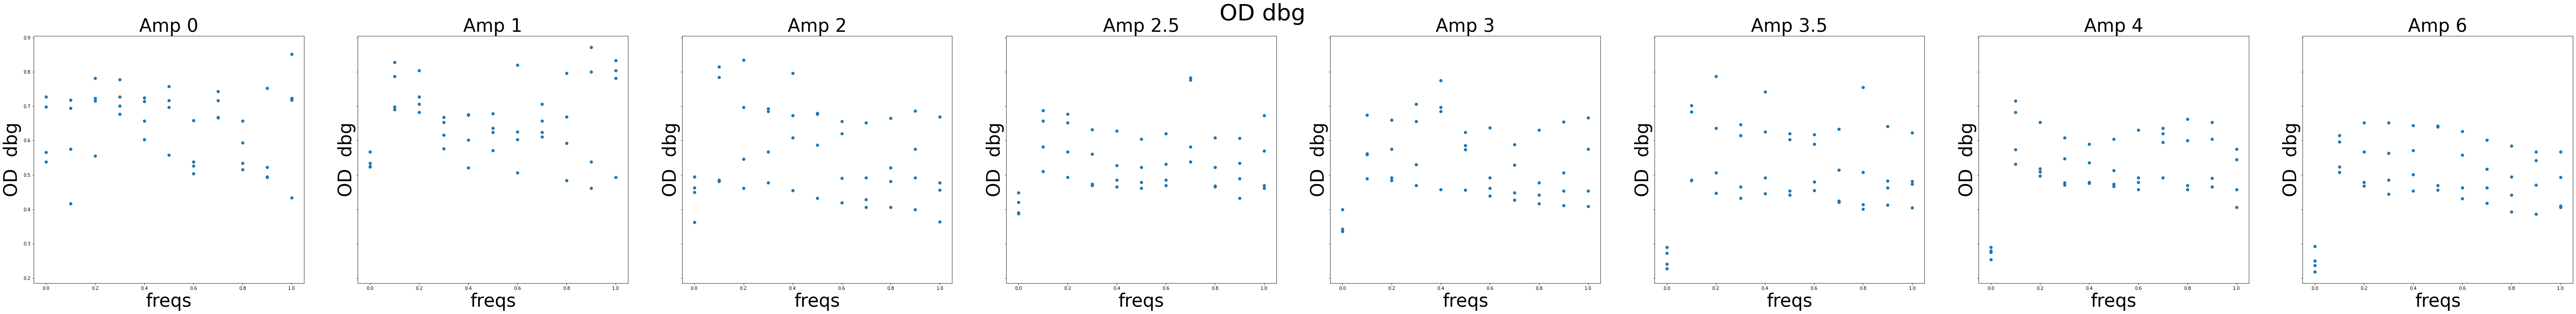

24


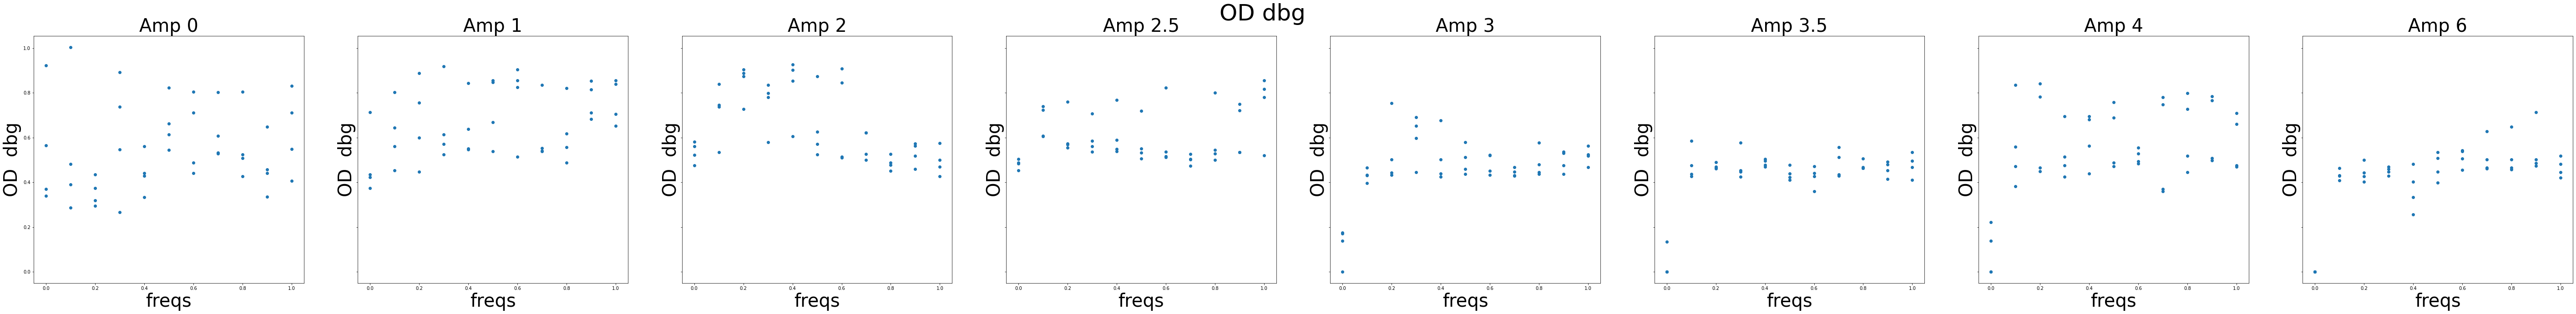

In [25]:
freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
cols=[x for x in np.arange(1,12)]
freqs_dict=dict(zip(cols,freqs))

for hr in time:
    print(hr)
    this_df=df_odDbg.copy()
    this_df=this_df[this_df["Time"]==hr]
    
    fig,axs=plt.subplots(1,len(amp_dict.keys()),sharex=True,sharey=True,figsize=(100,10))
    
    for ri,r in enumerate(amp_dict.keys()):
        amp=amp_dict[r]
        #print(amp)
        xs=[]
        ys=[]
        for ci,c in enumerate(freqs_dict.keys()):
            freq=freqs_dict[c]
            this_key=r+str(c)
            for rep in reps:

                vals=float(this_df[this_df["Rep"]==rep][this_key])
                #print(vals)
                xs.append(freq)
                ys.append(vals)
        #print(xs)
        #print(ys)        
        axs[ri].scatter(xs,ys)
                #axs[ri,ci].legend(fontsize="xx-large")
        
    

        axs[ri].set_title("Amp %s"%amp,size=40)
        axs[ri].set_ylabel("OD  dbg",size=40)
        axs[ri].set_xlabel("freqs",size=40)
        

# for ax, row in zip(axs[:,0], amps):
#     ax.set_ylabel(row, rotation=0, size=80)

    plt.suptitle("OD dbg",fontsize=50)
    plt.show()

### Plotting GFP dbg

In [26]:
df_gfpDbg

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H5,H6,H7,H8,H9,H10,H11,H12,Rep,Time
0,0.0,16555.0,30265.0,51318.0,65071.0,102869.0,86253.0,158393.0,126772.0,141211.0,...,74446.0,104563.0,113609.0,124214.0,134345.0,151662.0,176267.0,0.0,rep-1,16
1,0.0,24215.0,23269.0,55290.0,50111.0,65094.0,68199.0,90874.0,103605.0,82467.0,...,114944.0,148512.0,162121.0,157120.0,149579.0,162675.0,142981.0,0.0,rep-1,24
2,0.0,16561.0,40780.0,55032.0,71866.0,89534.0,95700.0,121221.0,135927.0,184378.0,...,91616.0,115604.0,127485.0,140732.0,151016.0,157857.0,183981.0,0.0,rep-2,16
3,0.0,8843.0,17332.0,44848.0,48438.0,86712.0,106249.0,134080.0,135181.0,124619.0,...,154328.0,162613.0,169914.0,188058.0,148875.0,146062.0,142676.0,0.0,rep-2,24
4,0.0,20745.0,42901.0,62095.0,84588.0,87294.0,98711.0,169388.0,159616.0,168230.0,...,75109.0,88469.0,98105.0,112015.0,140637.0,180990.0,185275.0,0.0,rep-3,16
5,0.0,8671.0,21263.0,26153.0,37919.0,73621.0,109875.0,118893.0,120932.0,114614.0,...,100725.0,198820.0,204250.0,189341.0,257367.0,279037.0,241720.0,0.0,rep-3,24
6,0.0,17194.0,34261.0,52005.0,74660.0,105728.0,98854.0,169166.0,139860.0,163877.0,...,75389.0,86043.0,99971.0,116915.0,122504.0,146203.0,174793.0,0.0,rep-4,16
7,0.0,11773.0,22660.0,33838.0,45378.0,77425.0,76792.0,104643.0,104335.0,142326.0,...,151241.0,158705.0,205832.0,186604.0,187539.0,190975.0,212476.0,0.0,rep-4,24


16


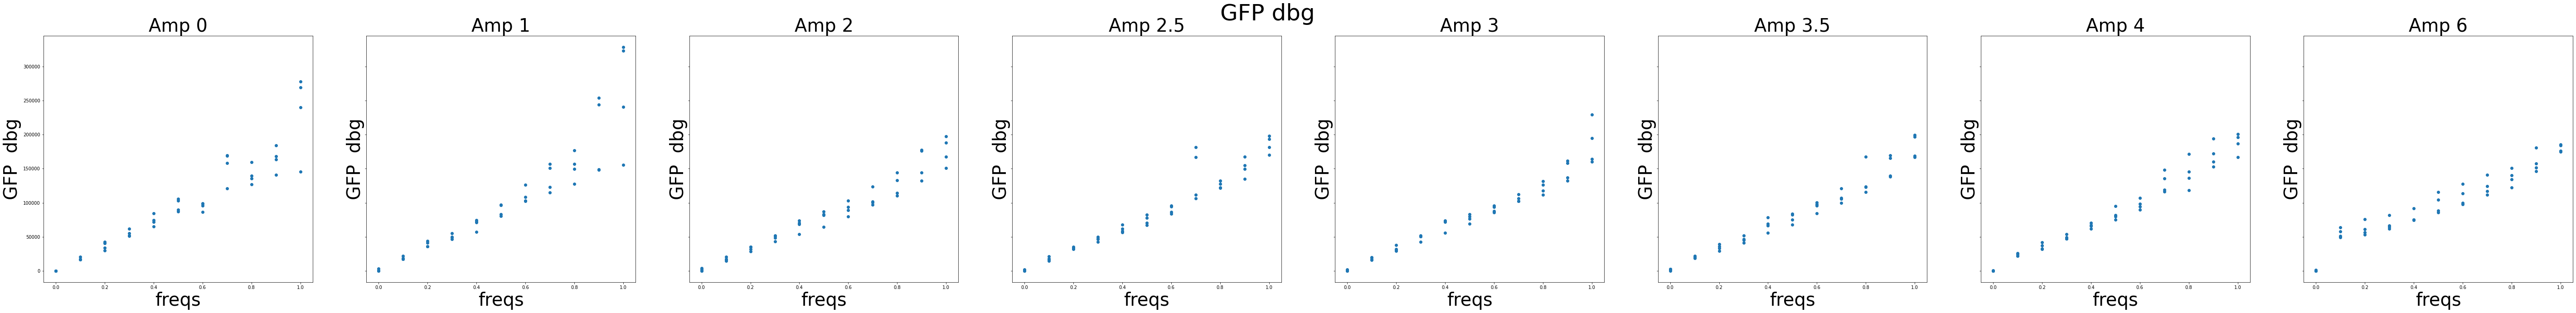

24


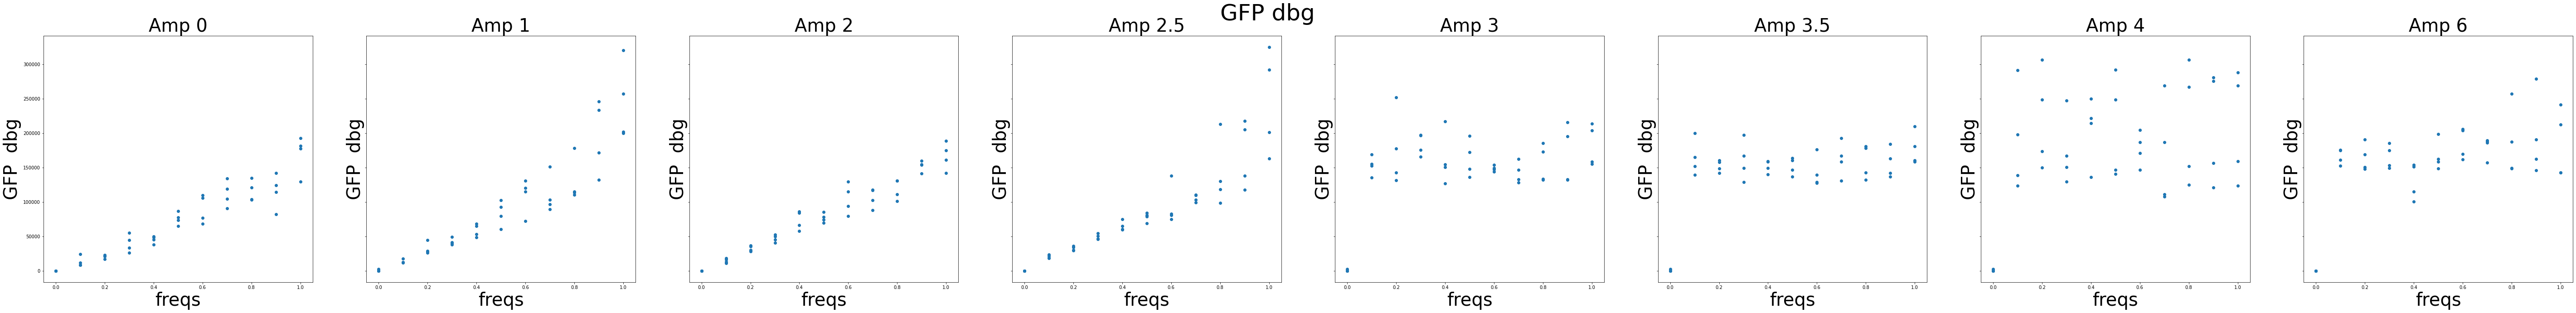

In [27]:

for hr in time:
    print(hr)
    this_df=df_gfpDbg.copy()
    this_df=this_df[this_df["Time"]==hr]
    
    fig,axs=plt.subplots(1,len(amp_dict.keys()),sharex=True,sharey=True,figsize=(100,10))
    
    for ri,r in enumerate(amp_dict.keys()):
        amp=amp_dict[r]
        #print(amp)
        xs=[]
        ys=[]
        for ci,c in enumerate(freqs_dict.keys()):
            freq=freqs_dict[c]
            this_key=r+str(c)
            for rep in reps:

                vals=float(this_df[this_df["Rep"]==rep][this_key])
                #print(vals)
                xs.append(freq)
                ys.append(vals)
        #print(xs)
        #print(ys)        
        axs[ri].scatter(xs,ys)
                #axs[ri,ci].legend(fontsize="xx-large")
        
    

        axs[ri].set_title("Amp %s"%amp,size=40)
        axs[ri].set_ylabel("GFP  dbg",size=40)
        axs[ri].set_xlabel("freqs",size=40)
        

# for ax, row in zip(axs[:,0], amps):
#     ax.set_ylabel(row, rotation=0, size=80)

    plt.suptitle("GFP dbg",fontsize=50)
    plt.show()

### Plotting GFP/OD 

16


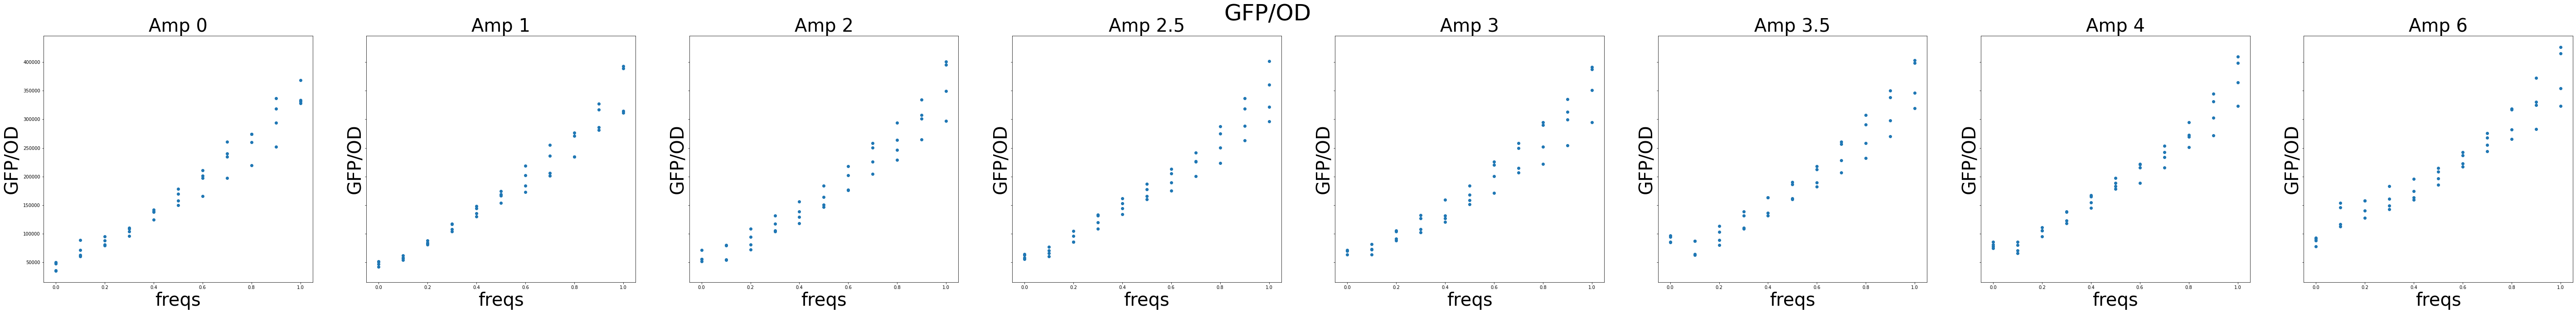

24


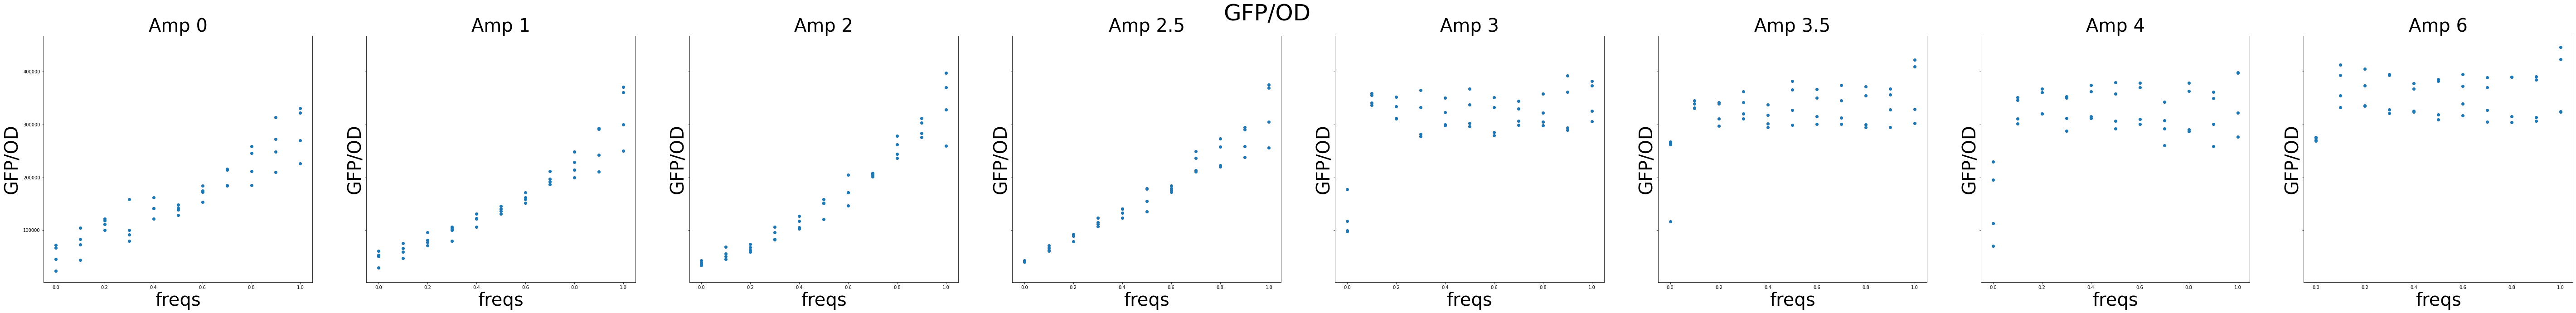

In [28]:
freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
cols=[x for x in np.arange(1,12)]
freqs_dict=dict(zip(cols,freqs))

for hr in time:
    print(hr)
    this_df=df_ratioLocal.copy()
    this_df=this_df[this_df["Time"]==hr]
    
    fig,axs=plt.subplots(1,len(amp_dict.keys()),sharex=True,sharey=True,figsize=(100,10))
    
    for ri,r in enumerate(amp_dict.keys()):
        amp=amp_dict[r]
        #print(amp)
        xs=[]
        ys=[]
        for ci,c in enumerate(freqs_dict.keys()):
            freq=freqs_dict[c]
            this_key=r+str(c)
            for rep in reps:

                vals=float(this_df[this_df["Rep"]==rep][this_key])
                #print(vals)
                xs.append(freq)
                ys.append(vals)
        #print(xs)
        #print(ys)        
        axs[ri].scatter(xs,ys)
        
                #axs[ri,ci].legend(fontsize="xx-large")
        
    

        axs[ri].set_title("Amp %s"%amp,size=40)
        axs[ri].set_ylabel("GFP/OD",size=40)
        axs[ri].set_xlabel("freqs",size=40)
        

# for ax, row in zip(axs[:,0], amps):
#     ax.set_ylabel(row, rotation=0, size=80)

    plt.suptitle("GFP/OD",fontsize=50)
    plt.show()

### Plotting GFP/OD dbg

16


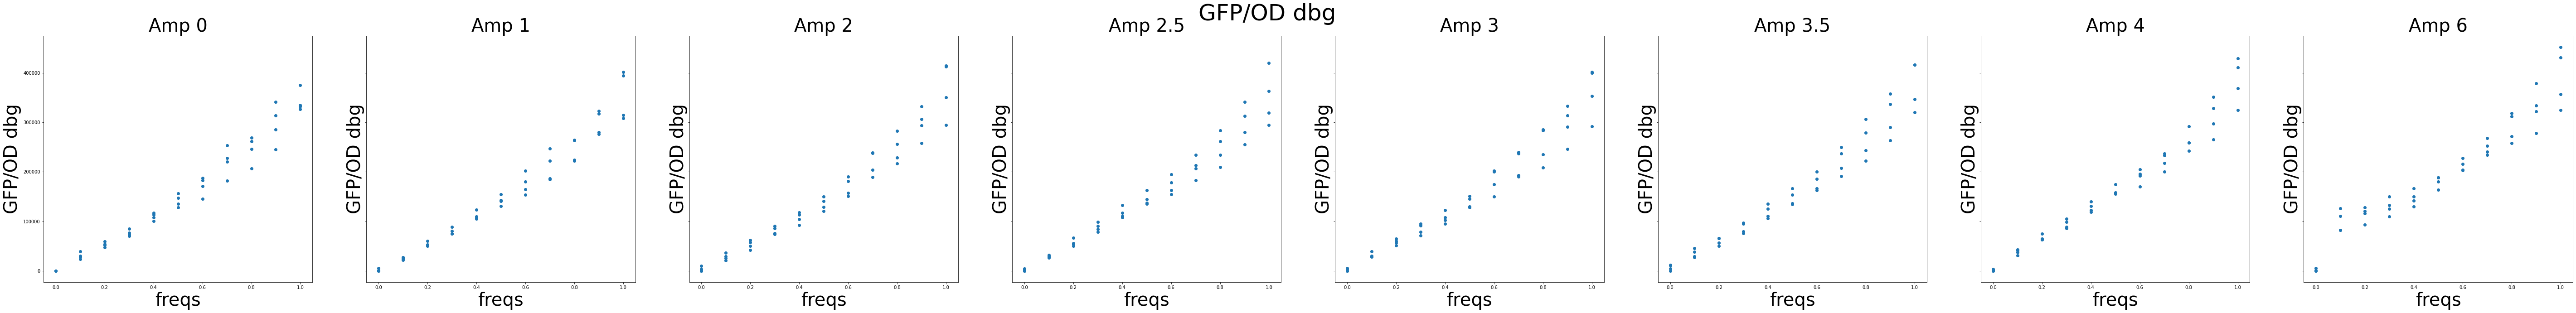

24


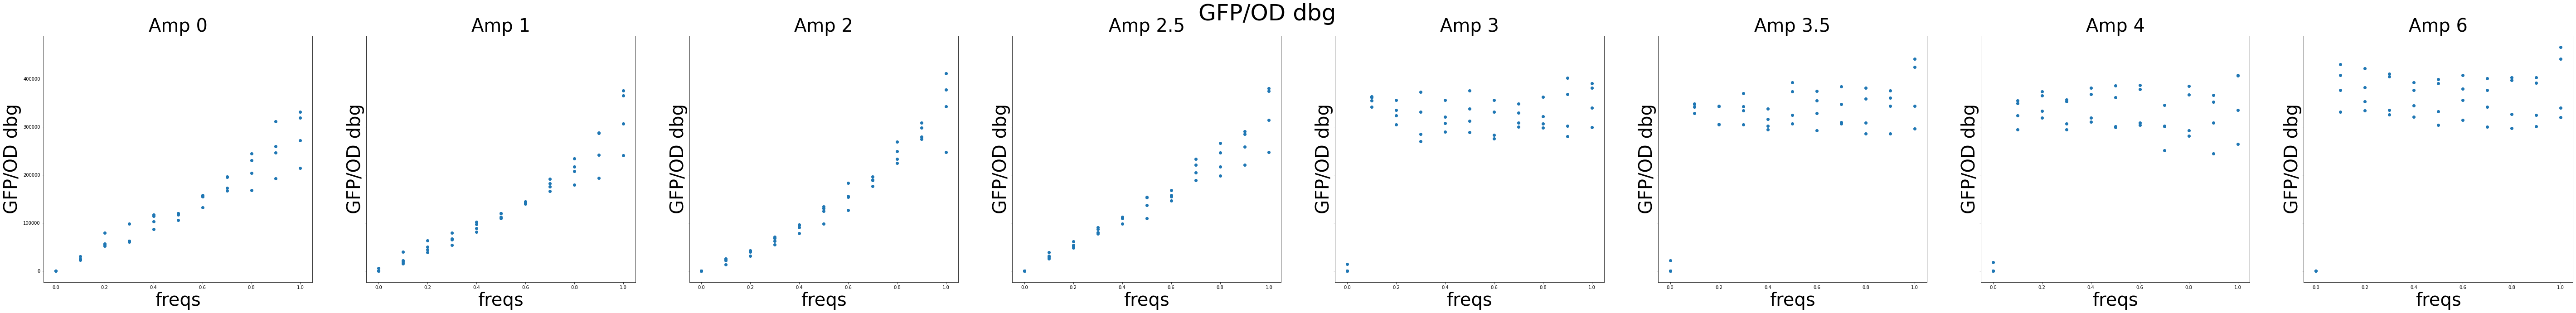

In [29]:

for hr in time:
    print(hr)
    this_df=df_ratioLocalDbg.copy()
    this_df=this_df[this_df["Time"]==hr]
    
    fig,axs=plt.subplots(1,len(amp_dict.keys()),sharex=True,sharey=True,figsize=(100,10))
    
    for ri,r in enumerate(amp_dict.keys()):
        amp=amp_dict[r]
        #print(amp)
        xs=[]
        ys=[]
        for ci,c in enumerate(freqs_dict.keys()):
            freq=freqs_dict[c]
            this_key=r+str(c)
            for rep in reps:

                vals=float(this_df[this_df["Rep"]==rep][this_key])
                #print(vals)
                xs.append(freq)
                ys.append(vals)
        #print(xs)
        #print(ys)        
        axs[ri].scatter(xs,ys)
                #axs[ri,ci].legend(fontsize="xx-large")
        
    

        axs[ri].set_title("Amp %s"%amp,size=40)
        axs[ri].set_ylabel("GFP/OD dbg",size=40)
        axs[ri].set_xlabel("freqs",size=40)
        

# for ax, row in zip(axs[:,0], amps):
#     ax.set_ylabel(row, rotation=0, size=80)

    plt.suptitle("GFP/OD dbg",fontsize=50)
    plt.show()

## Saving dataframes


In [30]:
file=dfs_path+"ratioLocalDbg.csv"
df_ratioLocalDbg.to_csv(file,sep=",",index_label=False)
file=dfs_path+"ONratioLocalDbg.csv"
df_ONratioLocalDbg.to_csv(file,sep=",",index_label="Well")
file=dfs_path+"ratioLocal.csv"
df_ratioLocal.to_csv(file,sep=",",index_label=False)
file=dfs_path+"ratio.csv"
df_ratio.to_csv(file,sep=",",index_label=False)
file=dfs_path+"odDbg.csv"
df_odDbg.to_csv(file,sep=",",index_label=False)
file=dfs_path+"GfpDbg.csv"
df_gfpDbg.to_csv(file,sep=",",index_label=False)


